In [1]:
import torch 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from cdft.dft1d import dft_core
from cdft.lj_eos import lj_eos

torch.set_default_dtype(torch.float64)
device = torch.device('cpu')

pi = np.pi
kB = 1.380649e-23
NA = 6.02214076e23

plt.rcParams.update({'text.usetex':True, 
'font.family':'serif', 
'font.size':18, 
})

In [2]:
sigma = 3.849
epsilon = 94.45
parameters = {'sigma':sigma, 'epsilon':epsilon}

In [3]:
T = 77.4
eos = lj_eos(parameters, T)
P = torch.hstack((torch.arange(1e-7,1e-6,0.5e-7),torch.arange(1e-6,1e-5,0.5e-6),
                 torch.arange(1e-5,1e-4,0.5e-5),torch.arange(1e-4,1e-3,0.5e-4),
                 torch.arange(1e-3,1e-2,0.5e-3), torch.arange(1e-2,1e-1,0.5e-2),
                 torch.arange(0.1,0.2,0.01), torch.arange(0.2,1.0,0.02)))*1e5

bulk_density = torch.empty_like(P)

bulk_density[0] = eos.density(P[0],'vap')
for i in range(1,len(P)):
    bulk_density[i] = eos.density(P[i],bulk_density[i-1])

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_11011/1789170785.py:1: SyntaxWarning: invalid escape sequence '\s'
  nist = pd.read_csv('data/N2_77K_NIST.txt', sep='\s+', skiprows=1,


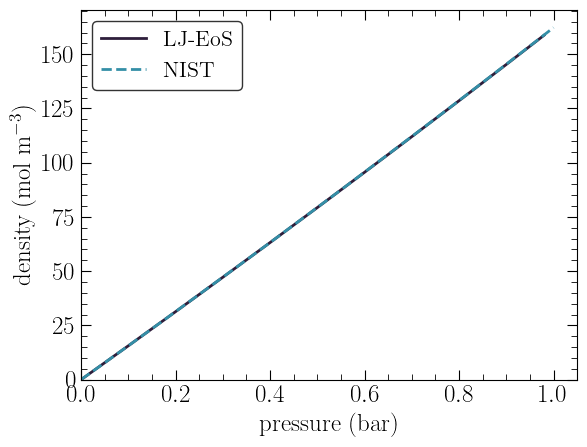

In [4]:
nist = pd.read_csv('data/N2_77K_NIST.txt', sep='\s+', skiprows=1, 
                    usecols=[1,2], names=['Pressure (bar)','Density (mol/m3)'])

colors = sns.color_palette("mako")

plt.plot(P*1e-5, bulk_density*1e30/(NA), '-', color=colors[0], linewidth=2.0, label='LJ-EoS')
plt.plot(nist['Pressure (bar)'],nist['Density (mol/m3)'], '--', color=colors[3], linewidth=2.0, label='NIST')
plt.xlabel(r'pressure (bar)', fontsize=18)
plt.ylabel(r'density (mol m$^{-3}$)', fontsize=18)
plt.xlim([0.0,None])
plt.ylim([0.0,None])
plt.minorticks_on()
plt.tick_params(direction='in',right=True, top=True)
plt.tick_params(labelsize=18)
plt.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
# xticks = np.arange(0, 1e4,10)
# yticks = np.arange(0,16.1,4)
plt.tick_params(direction='in',which='minor', length=4, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=7, bottom=True, top=True, left=True, right=True)
# plt.xticks(xticks)
# plt.yticks(yticks)
plt.legend(fontsize=16, frameon=True, edgecolor='k')

In [5]:
H = 20.0
system_size = H+10
points = int(system_size*100)

def steele(z,sigma,epsilon):
    rhos = 0.114
    Delta = 3.35
    return 2.0*pi*rhos*epsilon*sigma**2*Delta*(0.40*(sigma/z)**10-(sigma/z)**4-sigma**4/(3.0*Delta*(z+0.610*Delta)**3))

sigma_s = 3.40
epsilon_s = 28.0
sigma_is = 0.5*(sigma+sigma_s) 
epsilon_is = np.sqrt(epsilon*epsilon_s)

dft = dft_core(parameters, T, system_size, points, device)
Vext = torch.zeros_like(dft.z)
kin = 500
kout = int(system_size*100-kin)
Vext[0:kin] = np.inf
Vext[kout:] = np.inf
Vext[kin:kout] = steele(dft.z[kin:kout]-5, sigma_is, epsilon_is)+steele(H-(dft.z[kin:kout]-5), sigma_is, epsilon_is)

In [6]:
dft.initial_condition(bulk_density[0],Vext)
Nads = torch.empty_like(P)
Ndes = torch.empty_like(P) 
Omega_ads = torch.empty_like(P)
Omega_des = torch.empty_like(P)

for i in range(len(P)):
    dft.equilibrium_density_profile(bulk_density[i],fmt='ASWB',solver='anderson',
                                    anderson_mmax=10, anderson_damping=0.1, tol=1e-10,max_it=10000,logoutput=False)
    Nads[i] = dft.total_molecules 
    Omega_ads[i] = dft.Omega
    print(dft.it,dft.error.numpy(),1e-5*P[i].numpy(),Nads[i].numpy())   
    if np.isnan(dft.error.numpy()): break

7 1.4088293861529433e-12 1.0000000000000001e-07 1.7837831004507803e-05
6 1.3680337540686057e-11 1.5000000000000002e-07 2.6765472803533387e-05
6 9.422185265099609e-11 2.0000000000000002e-07 3.569894238165533e-05
6 2.4867359249131143e-11 2.5e-07 4.463824742525698e-05
6 9.946202635094478e-11 3.0000000000000004e-07 5.3583395655145045e-05
6 3.6120126216071217e-11 3.5e-07 6.253439482669966e-05
6 2.164733513918043e-12 4.0000000000000003e-07 7.14912526752618e-05
6 4.601359352829229e-12 4.5000000000000003e-07 8.045397696661512e-05
6 1.5161242337657942e-11 5e-07 8.942257549174426e-05
6 4.040701340807363e-11 5.5e-07 9.839705603824009e-05
6 8.0918228312865e-13 6.000000000000001e-07 0.00010737742644881434
6 1.4538672679336838e-11 6.499999999999999e-07 0.00011636369454112464
6 1.9446147521855095e-11 7e-07 0.00012535586816111
6 1.3826070427366538e-11 7.5e-07 0.00013435395519911263
6 3.7541372711879704e-11 8.000000000000001e-07 0.0001433579635105248
6 1.494907829956833e-11 8.5e-07 0.000152367901031150

In [ ]:
Ndes[-1] = dft.total_molecules
Omega_des[-1] = dft.Omega
for i in range(len(P)-2,-1,-1):
    dft.equilibrium_density_profile(bulk_density[i],fmt='ASWB',solver='fire',
                                    alpha0=0.1,dt=0.01,tol=1e-6,logoutput=False)
    Ndes[i] = dft.total_molecules 
    Omega_des[i] = dft.Omega
    print(dft.it,dft.error.numpy(),1e-5*P[i].numpy(),Ndes[i].numpy())   
    if np.isnan(dft.error.numpy()): break

In [ ]:
Neq = np.copy(Nads)
Omega_eq = np.copy(Omega_ads)
for i in range(len(P)):
    if Omega_des[i] < Omega_ads[i]:
        Omega_eq[i] = Omega_des[i]
        Neq[i] = Ndes[i]

In [ ]:
colors = sns.color_palette("mako")

plt.plot(P*1e-5, (1e23/NA)*Nads, '-', color=colors[2], linewidth=2.0, label='cDFT adsorption')
plt.plot(P*1e-5, (1e23/NA)*Ndes, '--', color=colors[2], linewidth=2.0, label='cDFT desorption')
plt.plot(P*1e-5, (1e23/NA)*Neq, ':', color=colors[2], linewidth=2.0, label='cDFT equilibrium')
plt.xlabel(r'$P$ (bar)', fontsize=18)
plt.ylabel(r'Adsorption (mmol/m$^2$)', fontsize=18)
plt.xlim([-0.01,0.2])
# plt.ylim([0.0,2000])
plt.minorticks_on()
plt.tick_params(direction='in',right=True, top=True)
plt.tick_params(labelsize=18)
plt.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
plt.tick_params(direction='in',which='minor', length=4, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=7, bottom=True, top=True, left=True, right=True)
plt.legend(fontsize=16, frameon=True, edgecolor='k')

In [ ]:
colors = sns.color_palette("mako")

plt.plot(P*1e-5, Omega_ads, '-', color=colors[2], linewidth=2.0, label='adsorption')
plt.plot(P*1e-5, Omega_des, '--', color=colors[2], linewidth=2.0, label='desorption')
plt.xlabel(r'$P$ (bar)', fontsize=18)
plt.ylabel(r'$\Omega/k_B T$', fontsize=18)
plt.xlim([-0.01,0.2])
# plt.ylim([0.0,2000])
plt.minorticks_on()
plt.tick_params(direction='in',right=True, top=True)
plt.tick_params(labelsize=18)
plt.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
plt.tick_params(direction='in',which='minor', length=4, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=7, bottom=True, top=True, left=True, right=True)
plt.legend(fontsize=16, frameon=True, edgecolor='k')